In [30]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
from sklearn.metrics import classification_report, confusion_matrix

# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [13]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "data_msg_type/"
X_path = dataset_path + "semantic_sim.txt"
y_path = dataset_path + "semantic_label_index.txt"

X = load_X(X_path)
y = load_y(y_path)
x = X.reshape(len(X), 1, 10, 14)

# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_y.shape)

Separating data into 80% training set & 20% test set...
Dataset separated.

((80000, 1, 10, 14), (80000, 14), (20000, 14))


# define parameters

In [17]:
input_height = 1
input_width = 10
num_channels = 14
num_labels = 14

batch_size = 100
kernel_size = 5
depth = 14
num_hidden = 100

learning_rate = 0.0001
# iteration times
training_epochs = 200
lstm_size = 128

total_batches = train_x.shape[0] // batch_size

n_classes = 14
n_hidden = 128
n_inputs = 14

rnnW = {
    'hidden': tf.Variable(tf.random_normal([n_inputs, n_hidden])),
    'output': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
rnnBiases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden], mean=1.0)),
    'output': tf.Variable(tf.random_normal([n_classes]))
}

# netowrk config

In [6]:
# init nn parameters
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

# conv
def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

# build network

In [7]:
c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
print(c.shape)
p = apply_max_pool(c,2,1)
c2 = apply_depthwise_conv(p,5,depth*num_channels,depth//14)
print(c2.shape)
c2Reshape = tf.reshape(c2, [-1, 14, n_inputs])
shuff = tf.transpose(c2Reshape, [1, 0, 2])
shuff = tf.reshape(shuff, [-1, n_inputs])

# Linear activation, reshaping inputs to the LSTM's number of hidden:
hidden = tf.nn.relu(tf.matmul(shuff, rnnW['hidden']) + rnnBiases['hidden'])
print(hidden.shape)

# Split the series because the rnn cell needs time_steps features, each of shape:
hidden = tf.split(axis=0, num_or_size_splits=14,value=hidden)

lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(lstm_size, forget_bias=1.0, 
                                          state_is_tuple=True)
lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(lstm_size, forget_bias=1.0, 
                                          state_is_tuple=True)

# Stack two LSTM layers, both layers has the same shape
lstm_layers = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], 
                                          state_is_tuple=True)

lstmOutputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)
lstmLastOutput = lstmOutputs[-1]
y_ = tf.matmul(lstmLastOutput, rnnW['output']) + rnnBiases['output']
print(y_.shape)

(?, 1, 6, 196)
(?, 1, 1, 196)
(?, 128)
(?, 14)


# batch config

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

# train and test

In [ ]:
test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


with tf.name_scope("cost"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_, labels=Y))
    # optimizer = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(loss)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=
                                                  learning_rate).minimize(loss)

    # Add scalar summary for cost
    tf.summary.scalar("loss", loss)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(y_, 1)) 
    # Count correct predictions
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float")) 
    # Cast boolean to float to average
    # Add scalar summary for accuracy
    tf.summary.scalar("accuracy", accuracy)


print("net work done")

cost_history = np.empty(shape=[1],dtype=float)

with tf.Session(config=sess_config) as sess:
    # create a log writer. run 'tensorboard --logdir=./logs/nn_logs'
    writer = tf.summary.FileWriter("data/cnn_lstm_logs", sess.graph)  # for 1.0
    merged = tf.summary.merge_all()

    tf.global_variables_initializer().run()
    
    step = 1
    for epoch in range(training_epochs):
        batch_x = extract_batch_size(train_x, step, batch_size)
        batch_y = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, cost, acc = sess.run([optimizer, loss, accuracy],
            feed_dict={X: batch_x, Y: batch_y})

        train_losses.append(cost)
        train_accuracies.append(acc)  
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, accs = sess.run([y_, loss, accuracy], 
                                    feed_dict={X: batch_xt, Y: batch_yt})
        
        test_losses.append(test_loss)
        test_accuracies.append(accs)
        test_predictions.append(test_predict)
            
        summary, acc = sess.run([merged, accuracy], 
                        feed_dict={X: batch_xt, Y: batch_yt})
        
        print ("Epoch: ",epoch," Training Loss: ",cost," Training Accuracy: ", acc)
        writer.add_summary(summary, epoch)  # Write summary

        print ("Testing Accuracy:", accs)
        writer.close()
        
        step += 1

# confusion matrix

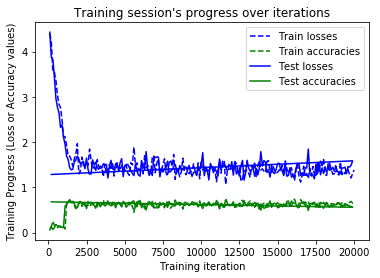

In [41]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)

#width = 12
#height = 12
#plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
    (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
    len(test_losses)*batch_size, batch_size)), [training_epochs])

plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

# multi-class confusion matrix and metrics plot

In [51]:
# Results
predictions = test_predictions
print(test_y.shape)
print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    test_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(test_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(test_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(test_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    y_test, predictions, target_names = list(fault_label.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)

200
(20000, 14)
Testing Accuracy: Tensor("mul_14:0", shape=(), dtype=float32)%



ValueError: Found input variables with inconsistent numbers of samples: [20000, 200]